In [242]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from operator import itemgetter
from tqdm import tqdm
import re
import transformers
import torch
import gensim
from itertools import combinations
import requests
import time
from dask.diagnostics import ProgressBar
import dask
from scipy.spatial.distance import cosine
import difflib
from ast import literal_eval
from pprint import pprint

from transformers import MarianTokenizer, MarianMTModel
import gensim.parsing.preprocessing as pp
import re
from pymorphy2 import MorphAnalyzer

from concurrent.futures import ThreadPoolExecutor

from tqdm import tqdm
from tqdm.auto import tqdm
import dask.dataframe as dd
from IPython.display import clear_output 

tqdm.pandas()

m = MorphAnalyzer()

sns.set_style("whitegrid")
sns.set_context("talk")


warnings.filterwarnings("ignore")

In [3]:
items = pd.read_csv("dataprocessing_items_202305252034.csv")
items.sample(5)

,id,name
20176,24307,Понимание разницы между субъективным и объекти...
15834,23615,International experience in transport planning
7787,22276,Mathematical description of electromagnetic waves
10824,13939,Количественные методы
12493,15950,Оптические методы измерения


In [4]:
init_n = items.shape[0]
init_n

22195

### Посмотрим на 100% совпадения

In [5]:
duplicates1 = items[items.duplicated(subset="name", keep=False)]
duplicates1

,id,name
2,148,Обходы графов
8,21783,Моделирование оптических процессов
19,21753,Ферментные препараты
40,255,Аналитическая геометрия
44,24233,Diffraction of rays in crystals
...,...,...
22116,24951,The structure of the DNA molecule
22159,24421,Теплоиспользующие холодильные машины
22163,24234,Diffraction of rays in crystals
22172,23083,Создание творческих проектов по каждому из осн...


In [6]:
items["dups1"] = items.name.apply(lambda val: duplicates1[duplicates1.name == val][["id", "name"]].values.tolist())
items

,id,name,dups1
0,26876,Основные микробиологические методы исследования,[]
1,15,Геометрия,[]
2,148,Обходы графов,"[[148, Обходы графов], [19996, Обходы графов]]"
3,245,Метод Гаусса,[]
4,115,Корреляция,[]
...,...,...,...
22190,19373,Страны Восточной Европы: борьба за выбор своег...,[]
22191,19304,Проектирование комплексов бортового оборудован...,[]
22192,19136,Корректировка технологического процесса с цель...,[]
22193,19058,Разработка и сборка наукоемких сервисов для мо...,[]


In [7]:
items.drop_duplicates(subset="name", inplace=True, keep="first")
force_n = items.shape[0]

In [8]:
print(f"Удалили {init_n-force_n} дубликатов")

Удалили 503 дубликатов


### Если в нижнем регистре сущности совпадают - это дубликаты.

In [9]:
items["lowercase"] = items.name.str.lower()
duplicates2 = items[items.duplicated(subset="lowercase", keep=False)]
items["dups2"] = items.lowercase.apply(lambda val: duplicates2[duplicates2.lowercase == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups2
items.drop_duplicates(subset="lowercase", inplace=True, keep="first")
lower_n = items.shape[0]

In [10]:
print(f"Удалили {force_n-lower_n} дубликатов")
print(f"Всего удалили {init_n-lower_n} сущностей")

Удалили 65 дубликатов
Всего удалили 568 сущностей


### Аккуратно срежем пунктуацию

In [11]:
def gently_remove_punkt(text):
    text = re.sub(r"\(.*?\)", " ", text)  # срезаем скобки с текстом внутри
    text = re.sub(r"[^\w+#]", " ", text)  # убираем всю остальную пунктуацию
    text = text.replace("ё","е")
    text = text.split()
    # if text[0].isdigit():
    #     text = text[1:]
    text = " ".join(text)
    text = text.strip()
    return text

items["no_punkt"] = items.lowercase.apply(gently_remove_punkt)

In [12]:
duplicates3 = items[items.duplicated(subset="no_punkt", keep=False)]
items["dups3"] = items.no_punkt.apply(lambda val: duplicates3[duplicates3.no_punkt == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups3
items.drop_duplicates(subset="no_punkt", inplace=True, keep="first")
punkt_n = items.shape[0]

print(f"Удалили {lower_n-punkt_n} дубликатов")
print(f"Всего удалили {init_n-punkt_n} сущностей")

Удалили 140 дубликатов
Всего удалили 708 сущностей


### Сущности не могут быть слишком длинными

In [13]:
items["length"] = items.no_punkt.apply(lambda val: len(val.split()))
items.nlargest(columns="length", n=5)

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length
22189,19806,определять степени принадлежности элементов за...,[],определять степени принадлежности элементов за...,[],определять степени принадлежности элементов за...,[],85
22188,19825,навыки решения следующих практических задач: п...,[],навыки решения следующих практических задач: п...,[],навыки решения следующих практических задач по...,[],74
21574,19828,навыки решения следующих практических задач: п...,[],навыки решения следующих практических задач: п...,[],навыки решения следующих практических задач по...,[],73
21585,19823,"умение доказывать, что: заданный неограф являе...",[],"умение доказывать, что: заданный неограф являе...",[],умение доказывать что заданный неограф являетс...,[],61
21590,19814,навыки решения следующих практических задач: н...,[],навыки решения следующих практических задач: н...,[],навыки решения следующих практических задач на...,[],57


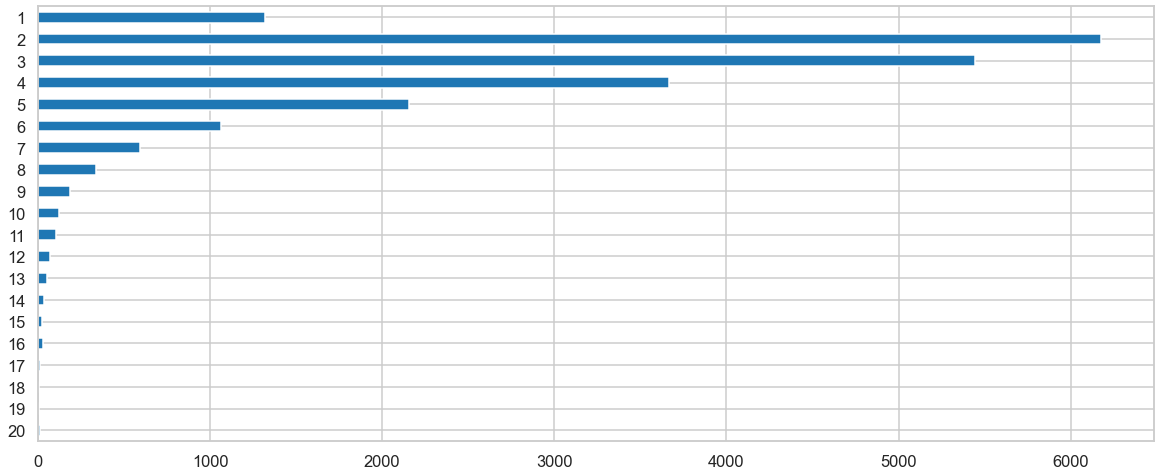

In [14]:
items.length.value_counts().sort_index()[:20].sort_index(ascending=False).plot(kind="barh", figsize=(20,8));

Уберем все сущности, где больше 6 слов.

In [15]:
items = items.query("length <= 6")
length_n = items.shape[0]


In [16]:
print(f"Удалили {punkt_n-length_n} некорректных сущностей")
print(f"Всего удалили {init_n-length_n} сущностей")

Удалили 1663 некорректных сущностей
Всего удалили 2371 сущностей


### Одни и те же сущности могут быть записаны на разных языках

In [17]:
HELSINKI_MODEL_NAME = 'Helsinki-NLP/opus-mt-en-ru'
marian_tokenizer = MarianTokenizer.from_pretrained(HELSINKI_MODEL_NAME)
tranlation_model = MarianMTModel.from_pretrained(HELSINKI_MODEL_NAME)

In [18]:
def translate(name):
    if not all(map(lambda x: "a" <= x <= "z" or "A" <= x <= "Z" or x.isspace() or x.isdigit() or x in ("+", "#"), name)):
        return name
    tokenizer = marian_tokenizer(name, return_tensors='pt', truncation=True, padding=True)
    seq = tranlation_model.generate(**tokenizer)
    return marian_tokenizer.decode(seq[0], skip_special_tokens=True)

In [20]:
items["translated"] = items.no_punkt.apply(translate)
items["translated"] = items.translated.apply(str.lower).apply(gently_remove_punkt)

In [21]:
duplicates4 = items[items.duplicated(subset="translated", keep=False)]
items["dups4"] = items.translated.apply(lambda val: duplicates4[duplicates4.translated == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups4
items.drop_duplicates(subset="translated", inplace=True, keep="first")
trans_n = items.shape[0]

In [22]:
print(f"Удалили {length_n-trans_n} дубликатов")
print(f"Всего удалили {init_n-trans_n} сущностей")

Удалили 586 дубликатов
Всего удалили 2957 сущностей


### Поиск сущностей с опечатками

In [ ]:
def check_spelling(word):
  domain = "https://speller.yandex.net/services/spellservice.json"
  response = requests.get(domain + "/checkText?text=" + word)
  try:
    return response.json()[0]["s"][0]
  except IndexError:
    return word

In [23]:
def process_response(url):
  response = requests.get(url)
  try:
      return response.json()[0]["s"][0]
  except IndexError:
    return url.split("=")[-1]


def yandex_spell_check(text):
  domain = "https://speller.yandex.net/services/spellservice.json"
  words = text.split()

  if len(words) == 1:
    return process_response(domain + "/checkText?text=" + words[0])
    
  elif len(words) > 1:
    urls = [domain + "/checkText?text=" + word for word in words]

    MAX_THREADS = 10
    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        results = list(executor.map(process_response, urls))
    return " ".join(results)

In [24]:
ddf = dd.from_pandas(items, npartitions=100)
ddf.compute()

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4
0,26876,Основные микробиологические методы исследования,[],основные микробиологические методы исследования,[],основные микробиологические методы исследования,[],4,основные микробиологические методы исследования,[]
1,15,Геометрия,"[[15, Геометрия], [22720, Геометрия.], [15, Ге...",геометрия,[],геометрия,"[[15, Геометрия], [22720, Геометрия.]]",1,геометрия,"[[15, Геометрия], [19750, Geometry]]"
2,148,Обходы графов,"[[148, Обходы графов], [19996, Обходы графов]]",обходы графов,[],обходы графов,[],2,обходы графов,[]
3,245,Метод Гаусса,[],метод гаусса,[],метод гаусса,[],2,метод гаусса,[]
4,115,Корреляция,"[[115, Корреляция], [19845, Correlation]]",корреляция,[],корреляция,[],1,корреляция,"[[115, Корреляция], [19845, Correlation]]"
...,...,...,...,...,...,...,...,...,...,...
22149,24902,Служба информационной безопасности,[],служба информационной безопасности,[],служба информационной безопасности,[],3,служба информационной безопасности,[]
22150,24898,Продакт-менеджмент,[],продакт-менеджмент,[],продакт менеджмент,[],2,продакт менеджмент,[]
22152,24896,Глобальные высококонкурентные рынки продуктов ...,[],глобальные высококонкурентные рынки продуктов ...,[],глобальные высококонкурентные рынки продуктов ...,[],5,глобальные высококонкурентные рынки продуктов ...,[]
22167,23672,Знание физических процессов являющихся основой...,[],знание физических процессов являющихся основой...,[],знание физических процессов являющихся основой...,[],6,знание физических процессов являющихся основой...,[]


In [33]:
items["spellchecked"] = items.no_punkt.progress_apply(yandex_spell_check)

100%|██████████| 19238/19238 [1:23:21<00:00,  3.85it/s]  


In [43]:
to_check = items[["name", "no_punkt", "spellchecked"]].query("no_punkt != spellchecked")

In [47]:
for i in to_check.index.values:
    display(to_check.loc[i])
    valid = input("Good check? y/n: ")
    if valid == "n":
        to_check.loc[i, "spellchecked"] = to_check.loc[i, "no_punkt"]
    clear_output()
    display(to_check.loc[i])

name            Sverchok Add-on for Blender
no_punkt        sverchok add on for blender
spellchecked    sverchok add on for blender
Name: 22126, dtype: object

In [48]:
to_check.query("no_punkt != spellchecked")

,name,no_punkt,spellchecked
10,Фильтер Калмана,фильтер калмана,фильтр калмана
62,Autolayot.,autolayot,auto layout
718,Магнитнорезонансная томография,магнитнорезонансная томография,магнитно резонансная томография
771,Кеширование,кеширование,кэширование
897,Взаимодествие излучения с веществом,взаимодествие излучения с веществом,взаимодействие излучения с веществом
...,...,...,...
21580,Экпертные системы,экпертные системы,экспертные системы
21628,Методы изготовления объемных наноструктрирован...,методы изготовления объемных наноструктрирован...,методы изготовления объемных наноструктурирова...
21799,Умение давать фидбек,умение давать фидбек,умение давать фидбэк
21808,Searching and analysing scientific information,searching and analysing scientific information,searching and analyzing scientific information


In [49]:
for i in to_check.index.values:
    items.loc[i, "spellchecked"] = to_check.loc[i, "spellchecked"]

In [50]:
items.query("no_punkt != spellchecked")

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4,spellchecked
10,256,Фильтер Калмана,[],фильтер калмана,[],фильтер калмана,[],2,фильтер калмана,[],фильтр калмана
62,14278,Autolayot.,[],autolayot.,[],autolayot,[],1,автолайот,[],auto layout
718,23102,Магнитнорезонансная томография,[],магнитнорезонансная томография,[],магнитнорезонансная томография,[],2,магнитнорезонансная томография,[],магнитно резонансная томография
771,1102,Кеширование,[],кеширование,[],кеширование,[],1,кеширование,[],кэширование
897,1434,Взаимодествие излучения с веществом,[],взаимодествие излучения с веществом,[],взаимодествие излучения с веществом,[],4,взаимодествие излучения с веществом,[],взаимодействие излучения с веществом
...,...,...,...,...,...,...,...,...,...,...,...
21580,18207,Экпертные системы,[],экпертные системы,[],экпертные системы,[],2,экпертные системы,[],экспертные системы
21628,6144,Методы изготовления объемных наноструктрирован...,[],методы изготовления объемных наноструктрирован...,[],методы изготовления объемных наноструктрирован...,[],5,методы изготовления объемных наноструктрирован...,[],методы изготовления объемных наноструктурирова...
21799,26814,Умение давать фидбек,[],умение давать фидбек,[],умение давать фидбек,[],3,умение давать фидбек,[],умение давать фидбэк
21808,26772,Searching and analysing scientific information,"[[26772, Searching and analysing scientific in...",searching and analysing scientific information,[],searching and analysing scientific information,[],5,поиск и анализ научной информации,"[[26772, Searching and analysing scientific in...",searching and analyzing scientific information


In [51]:
duplicates7 = items[items.duplicated(subset="spellchecked", keep=False)]
items["dups7"] = items.spellchecked.apply(lambda val: duplicates7[duplicates7.spellchecked == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups7
items.drop_duplicates(subset="spellchecked", inplace=True, keep="first")
spell_n = items.shape[0]

In [52]:
print(f"Удалили {trans_n-spell_n} дубликатов")
print(f"Всего удалили {init_n-spell_n} сущностей")

Удалили 36 дубликатов
Всего удалили 2993 сущностей


### Если совпадают наборы лемм, то это одинаковые сущности

In [53]:
def normalize(word):
    res = m.parse(word)[0]
    if word == "данные":
        return word
    if res.tag.POS == "PRTF":
        return gently_remove_punkt(res.inflect({"sing", "masc"}).word)
    return gently_remove_punkt(res.normal_form)

def input_preprocessing(text):
    return tuple(normalize(word) for word in text.split())

def embed(tokens, w2v_model):
  vectors = [w2v_model.wv.get_vector(token) for token in tokens if token in w2v_model.wv.index_to_key]
  vec = np.mean(vectors, axis=0) if len(vectors) != 0 else np.array([0]*300)
  return vec

In [54]:
items["lemmas"] = items.translated.apply(input_preprocessing)
items.sample(3)

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4,spellchecked,dups7,lemmas
6140,7898,Кинетическая энергия,[],кинетическая энергия,[],кинетическая энергия,[],2,кинетическая энергия,[],кинетическая энергия,[],"(кинетический, энергия)"
18041,13711,Троичная логика,[],троичная логика,[],троичная логика,[],2,троичная логика,[],троичная логика,[],"(троичный, логика)"
21037,20175,Forecasting functions,[],forecasting functions,[],forecasting functions,[],2,функции прогнозирования,[],forecasting functions,[],"(функция, прогнозирование)"


In [55]:
duplicates5 = items[items.duplicated(subset="lemmas", keep=False)]
items["dups5"] = items.lemmas.apply(lambda val: duplicates5[duplicates5.lemmas == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups5
items.drop_duplicates(subset="lemmas", inplace=True, keep="first")
lemms_n = items.shape[0]

In [56]:
print(f"Удалили {spell_n-lemms_n} дубликатов")
print(f"Всего удалили {init_n-lemms_n} сущностей")

Удалили 336 дубликатов
Всего удалили 3329 сущностей


In [57]:
items["set_lemmas"] = items.lemmas.apply(lambda val: tuple(sorted(set(val))))
items.sample(3)

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4,spellchecked,dups7,lemmas,dups5,set_lemmas
15828,7753,Нелинейная оптика в науке и технике,[],нелинейная оптика в науке и технике,[],нелинейная оптика в науке и технике,[],6,нелинейная оптика в науке и технике,[],нелинейная оптика в науке и технике,[],"(нелинейный, оптика, в, наука, и, техника)",[],"(в, и, наука, нелинейный, оптика, техника)"
10581,13645,Методология проведения испытаний,[],методология проведения испытаний,[],методология проведения испытаний,[],3,методология проведения испытаний,[],методология проведения испытаний,[],"(методология, проведение, испытание)",[],"(испытание, методология, проведение)"
7331,9282,Измерение структурно-механических свойств пище...,[],измерение структурно-механических свойств пище...,[],измерение структурно механических свойств пище...,[],6,измерение структурно механических свойств пище...,[],измерение структурно механических свойств пище...,[],"(измерение, структурно, механический, свойство...",[],"(измерение, масса, механический, пищевой, свой..."


### Если слова одинаковые, но перемешаны, то сущности одинаковые

In [58]:
duplicates6 = items[items.duplicated(subset="set_lemmas", keep=False)]
items["dups6"] = items.set_lemmas.apply(lambda val: duplicates6[duplicates6.set_lemmas == val][["id", "name"]].values.tolist())
items["dups1"] = items.dups1 + items.dups6
items.drop_duplicates(subset="set_lemmas", inplace=True, keep="first")
set_lemms_n = items.shape[0]

In [59]:
print(f"Удалили {lemms_n-set_lemms_n} дубликатов")
print(f"Всего удалили {init_n-set_lemms_n} сущностей")

Удалили 50 дубликатов
Всего удалили 3379 сущностей


In [60]:
items["len_trans"] = items.lemmas.apply(len)
to_search_dup = items.query("len_trans > 1")
to_search_dup.shape, items.shape

((17646, 17), (18816, 17))

In [268]:
items.query("translated == 'базы данных'")["dups1"].values

array([list([[726, 'Базы данных'], [13827, 'Базы данных'], [726, 'Базы данных'], [25258, 'Database']])],
      dtype=object)

### Сущность, скорее всего, некорректна, если в ней есть союз "и"

Пункт, конечно, классный, но не самый быстрый и актуальный.

In [205]:
# items["colloc"] = items.lemmas.apply(lambda x: [x[0], x[2]] if x.count("и")==1 and len(x)==3 else [])
# items = items.explode("colloc")
# items["colloc"] = items.apply(lambda x: x["colloc"] if x["colloc"] is not None else (x["lemmas"][0] if len(x["lemmas"])==1 else np.NaN), axis=1)
# duplicates7 = items[(items.colloc.notnull())]
# duplicates7 = comb_singles[comb_singles.duplicated(subset="colloc", keep=False)]
# items["dups6"] = items.set_lemmas.apply(lambda val: duplicates6[duplicates6.set_lemmas == val][["id", "name"]].values.tolist())
# items["dups1"] = items.dups1 + items.dups6
# items.drop_duplicates(subset="set_lemmas", inplace=True, keep="first")
# set_lemms_n = items.shape[0]


### Попытаемся найти аббревиатуры

In [269]:
items.sample()

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4,lemmas,dups5,set_lemmas,dups6,len_trans
7469,9417,FPGA,[],fpga,[],fpga,[],1,фпга,[],"(фпг,)",[],"(фпг,)",[],1


In [271]:
# удалим лишние столбцы
items.drop(columns=["dups2", "dups3", "dups4", "dups5", "dups6"], inplace=True)


In [272]:
# добавим столбец с аббревиатурами
items["abb"] = items.lemmas.apply(lambda x: x[0] if len(x) == 1 else "".join([y[0] for y in x]))
items[items.duplicated(subset="abb", keep=False)]

,id,name,dups1,lowercase,no_punkt,length,translated,lemmas,set_lemmas,len_trans,abb
2,148,Обходы графов,"[[148, Обходы графов], [19996, Обходы графов]]",обходы графов,обходы графов,2,обходы графов,"(обход, граф)","(граф, обход)",2,ог
3,245,Метод Гаусса,"[[245, Метод Гаусса], [1874, Методы Гаусса]]",метод гаусса,метод гаусса,2,метод гаусса,"(метод, гаусс)","(гаусс, метод)",2,мг
5,12640,Неценовая конкуренция,[],неценовая конкуренция,неценовая конкуренция,2,неценовая конкуренция,"(неценовой, конкуренция)","(конкуренция, неценовой)",2,нк
7,23091,Digital culture,"[[23091, Digital culture], [1081, Цифровая кул...",digital culture,digital culture,2,цифровая культура,"(цифровой, культура)","(культура, цифровой)",2,цк
8,21783,Моделирование оптических процессов,"[[21783, Моделирование оптических процессов], ...",моделирование оптических процессов,моделирование оптических процессов,3,моделирование оптических процессов,"(моделирование, оптический, процесс)","(моделирование, оптический, процесс)",3,моп
...,...,...,...,...,...,...,...,...,...,...,...
22125,24938,Основы менеджмента организации,[],основы менеджмента организации,основы менеджмента организации,3,основы менеджмента организации,"(основа, менеджмент, организация)","(менеджмент, организация, основа)",3,омо
22136,24918,Строение коллоидных мицелл,"[[24918, Строение коллоидных мицелл], [24917, ...",строение коллоидных мицелл,строение коллоидных мицелл,3,строение коллоидных мицелл,"(строение, коллоидный, мицелла)","(коллоидный, мицелла, строение)",3,скм
22145,24906,The quality of herbal products,[],the quality of herbal products,the quality of herbal products,5,качества травяных продуктов,"(качество, травяной, продукт)","(качество, продукт, травяной)",3,ктп
22149,24902,Служба информационной безопасности,[],служба информационной безопасности,служба информационной безопасности,3,служба информационной безопасности,"(служба, информационный, безопасность)","(безопасность, информационный, служба)",3,сиб


In [273]:
items.query("abb == 'ктп'")

,id,name,dups1,lowercase,no_punkt,length,translated,lemmas,set_lemmas,len_trans,abb
3954,5301,Классификация технологических процессов,[],классификация технологических процессов,классификация технологических процессов,3,классификация технологических процессов,"(классификация, технологический, процесс)","(классификация, процесс, технологический)",3,ктп
4348,24605,Concepts of technological paradigms,[],concepts of technological paradigms,concepts of technological paradigms,4,концепции технологических парадигм,"(концепция, технологический, парадигма)","(концепция, парадигма, технологический)",3,ктп
5551,7133,Квантовые технологии передачи,[],квантовые технологии передачи,квантовые технологии передачи,3,квантовые технологии передачи,"(квантовый, технология, передача)","(квантовый, передача, технология)",3,ктп
7364,9283,Контроль технологических процессов,[],контроль технологических процессов,контроль технологических процессов,3,контроль технологических процессов,"(контроль, технологический, процесс)","(контроль, процесс, технологический)",3,ктп
13846,17786,Контрольные точки производства,[],контрольные точки производства,контрольные точки производства,3,контрольные точки производства,"(контрольный, точка, производство)","(контрольный, производство, точка)",3,ктп
16981,20887,Классические теории политики,[],классические теории политики,классические теории политики,3,классические теории политики,"(классический, теория, политика)","(классический, политика, теория)",3,ктп
22145,24906,The quality of herbal products,[],the quality of herbal products,the quality of herbal products,5,качества травяных продуктов,"(качество, травяной, продукт)","(качество, продукт, травяной)",3,ктп


План нерабочий.

### Сущности не могут начинаться на глагол

In [62]:
items["first_pos"] = items.name.apply(lambda x: m.parse(x.split()[0])[0].tag.POS)
items = items[(items.first_pos != "INFN") & (items.id != 15065)]
verb_n = items.shape[0]

In [63]:
print(f"Удалили {set_lemms_n-verb_n} дубликатов")
print(f"Всего удалили {init_n-verb_n} сущностей")

Удалили 13 дубликатов
Всего удалили 3392 сущностей


### Сущности с очень высоким косинусным сходством эмбеддингов

In [72]:
items.sample()

,id,name,dups1,lowercase,dups2,no_punkt,dups3,length,translated,dups4,spellchecked,dups7,lemmas,dups5,set_lemmas,dups6,len_trans,first_pos,embedding
10678,24726,Kanban,[],kanban,[],kanban,[],1,канбан,[],kanban,[],"(канбан,)",[],"(канбан,)",[],1,None,"[0.19235583, 0.3141681, 0.011430377, -0.140947..."


In [73]:
items.drop(columns=["dups2", "dups3", "length", "dups4", "dups5", "dups6", "dups7", "set_lemmas", "first_pos", "embedding"], inplace=True)
items.sample(3)

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans
9578,22482,Проектированием мехатронных модулей,[],проектированием мехатронных модулей,проектированием мехатронных модулей,проектированием мехатронных модулей,проектированием мехатронных модулей,"(проектирование, мехатронный, модуль)",3
2275,3175,Адресация в ассемблере,[],адресация в ассемблере,адресация в ассемблере,адресация в ассемблере,адресация в ассемблере,"(адресация, в, ассемблер)",3
14955,22439,Фурье-фильтрация в конфокальном микроскопе,[],фурье-фильтрация в конфокальном микроскопе,фурье фильтрация в конфокальном микроскопе,фурье фильтрация в конфокальном микроскопе,фурье фильтрация в конфокальном микроскопе,"(фурье, фильтрация, в, конфокальный, микроскоп)",5


In [74]:
items.to_csv("items_dups_20240312.csv")

In [143]:
items = pd.read_csv("items_dups_20240312.csv")
items.head()

,Unnamed: 0,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans
0,0,26876,Основные микробиологические методы исследования,[],основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,"('основной', 'микробиологический', 'метод', 'и...",4
1,1,15,Геометрия,"[[15, 'Геометрия'], [22720, 'Геометрия.'], [15...",геометрия,геометрия,геометрия,геометрия,"('геометрия',)",1
2,2,148,Обходы графов,"[[148, 'Обходы графов'], [19996, 'Обходы графо...",обходы графов,обходы графов,обходы графов,обходы графов,"('обход', 'граф')",2
3,3,245,Метод Гаусса,"[[245, 'Метод Гаусса'], [1874, 'Методы Гаусса']]",метод гаусса,метод гаусса,метод гаусса,метод гаусса,"('метод', 'гаусс')",2
4,4,115,Корреляция,"[[115, 'Корреляция'], [19845, 'Correlation']]",корреляция,корреляция,корреляция,корреляция,"('корреляция',)",1


In [65]:
model = gensim.models.Word2Vec.load("w2v_rpd.bin")

In [144]:
items["embedding"] = items.spellchecked.apply(lambda val: embed(input_preprocessing(val), w2v_model=model))
items.sample(5)

,Unnamed: 0,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,embedding
16986,19655,26236,Неприводимые представления,[],неприводимые представления,неприводимые представления,неприводимые представления,неприводимые представления,"('неприводимый', 'представление')",2,"[-0.50806403, 0.17650685, -0.84570724, 0.77187..."
9220,9996,22032,Основное кинетическое уравнение,[],основное кинетическое уравнение,основное кинетическое уравнение,основное кинетическое уравнение,основное кинетическое уравнение,"('основный', 'кинетический', 'уравнение')",3,"[-0.47915474, 0.3710318, -0.15581323, 0.102565..."
5713,6178,7967,Наноструктуры,[],наноструктуры,наноструктуры,наноструктуры,наноструктуры,"('наноструктура',)",1,"[-0.76325434, 0.2311724, -0.0090661915, 0.8038..."
14882,16805,20790,Линейно упорядоченное множество (л.у.м.),[],линейно упорядоченное множество (л.у.м.),линейно упорядоченное множество,линейно упорядоченное множество,линейно упорядоченное множество,"('линейно', 'упорядоченный', 'множество')",3,"[-0.2913211, 0.3742175, -1.1513731, 0.06952379..."
10859,11781,15100,Алгоритмы обнаружения особых точек,[],алгоритмы обнаружения особых точек,алгоритмы обнаружения особых точек,алгоритмы обнаружения особых точек,алгоритмы обнаружения особых точек,"('алгоритм', 'обнаружение', 'особый', 'точка')",4,"[-0.24568, 0.45183593, -1.0687796, 0.74240565,..."


In [145]:
items["norm_embed"] = items.embedding.apply(lambda x: x / np.linalg.norm(x))
items.sample(3)

,Unnamed: 0,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,embedding,norm_embed
1072,1178,1654,Виртуальное управление бизнес-процессами,"[[1654, 'Виртуальное управление бизнес-процесс...",виртуальное управление бизнес-процессами,виртуальное управление бизнес процессами,виртуальное управление бизнес процессами,виртуальное управление бизнес процессами,"('виртуальный', 'управление', 'бизнес', 'проце...",4,"[0.30500084, 0.21570212, -0.04886396, -0.92964...","[0.025617229, 0.018116968, -0.0041041174, -0.0..."
5566,6024,7741,Физические основы квантовой информации,[],физические основы квантовой информации,физические основы квантовой информации,физические основы квантовой информации,физические основы квантовой информации,"('физический', 'основа', 'квантовый', 'информа...",4,"[-0.7540492, 0.05609761, -0.76730883, 0.841492...","[-0.057015117, 0.004241649, -0.058017705, 0.06..."
4706,5110,6756,Методы моделирования случайных событий,[],методы моделирования случайных событий,методы моделирования случайных событий,методы моделирования случайных событий,методы моделирования случайных событий,"('метод', 'моделирование', 'случайный', 'событ...",4,"[-1.3853196, -0.06080263, -0.7104165, 0.013892...","[-0.13135967, -0.005765466, -0.06736357, 0.001..."


In [75]:
from annoy import AnnoyIndex

In [151]:
matrix = AnnoyIndex(300, 'angular')
for i in items.index.values:
    matrix.add_item(i, items["norm_embed"][i])

matrix.build(1000, n_jobs=-1)
matrix.save("annoy_matrix.ann")

True

In [152]:
res = matrix.get_nns_by_item(0, 5, include_distances=True)
res


([0, 16682, 18660, 13153, 8104],
 [0.0003452671808190644,
  0.4141666293144226,
  0.4394669830799103,
  0.4397059381008148,
  0.44420647621154785])

In [153]:
print(*zip(res[0], res[1]))

(0, 0.0003452671808190644) (16682, 0.4141666293144226) (18660, 0.4394669830799103) (13153, 0.4397059381008148) (8104, 0.44420647621154785)


In [154]:
items[items.index.isin(res[0])][["id", "name"]].values

array([[26876, 'Основные микробиологические методы исследования'],
       [11375, 'Экспрессные методы исследования'],
       [24069, 'Количественные методы исследований'],
       [25927, 'Основные методы ядерно-физических исследований'],
       [26635, 'Методы эмпирических исследований']], dtype=object)

In [207]:
def get_similarity(vec1, vec2):
    return np.round(1-cosine(vec1, vec2), 5)


def get_most_similar_entities(ent):
    res, _ = matrix.get_nns_by_item(ent, 5, include_distances=True)
    ids = []
    for val in res:
        sim = difflib.SequenceMatcher(None, items["spellchecked"][ent], items["spellchecked"][val]).ratio()
        # sim = get_similarity(items["embedding"][ent], items["embedding"][val])
        if val != ent and sim >= 0.9:
            ids.append(val)
    return items[items.index.isin(ids)][["id", "name"]].values


In [208]:
items["sims"] = items.index.map(get_most_similar_entities)

In [209]:
items["sims_length"] = items.sims.apply(len)

In [192]:
items["has_abbr"] = items.name.str.contains(pat=r"\b[A-ZА-ЯЁ]{2,}\b", regex=True)

In [212]:
items.sample(2)

,index,Unnamed: 0,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,embedding,norm_embed,sims,sims_length,has_abbr
1561,1561,1714,2540,Задачи кластеризации,[],задачи кластеризации,задачи кластеризации,задачи кластеризации,задачи кластеризации,"('задача', 'кластеризация')",2,"[-0.068155736, 0.8246843, -0.38069573, 0.41220...","[-0.005237942, 0.063379094, -0.02925744, 0.031...",[],0,False
14122,14122,15704,19634,Публикационная политика в научных журналах,[],публикационная политика в научных журналах,публикационная политика в научных журналах,публикационная политика в научных журналах,публикационная политика в научных журналах,"('публикационный', 'политика', 'в', 'научный',...",5,"[0.57268286, 0.5178148, -0.565797, 0.006490208...","[0.08031888, 0.072623625, -0.07935313, 0.00091...",[],0,False


In [211]:
to_check = items.query("sims_length > 0 & has_abbr == False")

In [234]:
to_check

,index,Unnamed: 0,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,embedding,norm_embed,sims,sims_length,has_abbr
12,12,12,119,Метод ближайших соседей,[],метод ближайших соседей,метод ближайших соседей,метод ближайших соседей,метод ближайших соседей,"('метод', 'близкий', 'сосед')",3,"[-0.30470592, 0.5267608, -0.5426639, 0.2718882...","[-0.046475276, 0.08034421, -0.08276982, 0.0414...","[[341, Метод k-ближайших соседей]]",1,False
34,34,34,12548,Нанотехнологии в медицине,[],нанотехнологии в медицине,нанотехнологии в медицине,нанотехнологии в медицине,нанотехнологии в медицине,"('нанотехнология', 'в', 'медицина')",3,"[-0.06951036, -0.13634239, -0.22117303, -0.098...","[-0.008978281, -0.017610617, -0.028567735, -0....","[[8568, Нанотехнологии в биомедицине]]",1,False
67,67,68,4632,Численные методы решения задач теплопроводности,[],численные методы решения задач теплопроводности,численные методы решения задач теплопроводности,численные методы решения задач теплопроводности,численные методы решения задач теплопроводности,"('численный', 'метод', 'решение', 'задача', 'т...",5,"[-0.9152239, -0.014002705, -0.26485187, 0.5633...","[-0.073238164, -0.0011205263, -0.021194011, 0....","[[4570, Точные методы решения задач теплопрово...",1,False
84,84,87,324,Многомерные случайные величины,"[[324, 'Многомерные случайные величины'], [222...",многомерные случайные величины,многомерные случайные величины,многомерные случайные величины,многомерные случайные величины,"('многомерный', 'случайный', 'величина')",3,"[-1.3025497, -0.5854341, -0.38842082, 0.457369...","[-0.11038379, -0.049612258, -0.03291649, 0.038...",,1,False
85,85,88,323,Одномерные случайные величины,"[[323, 'Одномерные случайные величины'], [1644...",одномерные случайные величины,одномерные случайные величины,одномерные случайные величины,одномерные случайные величины,"('одномерный', 'случайный', 'величина')",3,"[-1.4716486, -0.7560525, -0.31990504, 0.479006...","[-0.12433926, -0.06387871, -0.027028706, 0.040...",,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18558,18558,21748,26836,Компоненты биомехатронных систем,[],компоненты биомехатронных систем,компоненты биомехатронных систем,компоненты биомехатронных систем,компоненты биомехатронных систем,"('компонент', 'биомехатронный', 'система')",3,"[-0.45023647, -0.36587253, -0.53261226, 0.2901...","[-0.05239752, -0.04257943, -0.061984234, 0.033...",,1,False
18559,18559,21749,26835,Детали биомехатронных систем,[],детали биомехатронных систем,детали биомехатронных систем,детали биомехатронных систем,детали биомехатронных систем,"('деталь', 'биомехатронный', 'система')",3,"[-0.81778604, -0.85767144, -0.560147, 0.122768...","[-0.09485599, -0.09948234, -0.064972125, 0.014...",,1,False
18560,18560,21750,26834,Правила проектирования биомехатронных систем,[],правила проектирования биомехатронных систем,правила проектирования биомехатронных систем,правила проектирования биомехатронных систем,правила проектирования биомехатронных систем,"('правило', 'проектирование', 'биомехатронный'...",4,"[-0.35306406, -0.439857, -0.36089355, 0.109380...","[-0.042145252, -0.052505724, -0.043079857, 0.0...",,1,False
18634,18634,21888,26686,Навык формирования финансового результата орга...,[],навык формирования финансового результата орга...,навык формирования финансового результата орга...,навык формирования финансового результата орга...,навык формирования финансового результата орга...,"('навык', 'формирование', 'финансовый', 'резул...",5,"[0.43455562, -0.050794043, -1.2719581, 0.39825...","[0.03786774, -0.0044262586, -0.110840075, 0.03...","[[26602, формирование финансового результата о...",1,False


Код для ручной проверки, действительно ли это одна и та же сущность.

In [217]:
for i in to_check.index.values:
    display(to_check.loc[i, "sims"])
    display(to_check.loc[i, "name"])
    valid = input("Good check? y/n: ")
    if valid == "n":
        to_check.loc[i, "sims"] = ""
    clear_output()
    display(to_check.loc[i, "sims"])
    display(to_check.loc[i, "name"])

array([[19205, 'Риски в сфере охраны интеллектуальной собственности']],
      dtype=object)

'Риски в сфере защиты интеллектуальной собственности'

Есть сущности, в которых, кажется, надо обладать экспертным знанием, чтобы решить, одинаковые ли они.

In [236]:
items.drop(columns=["index", "Unnamed: 0", "embedding", "norm_embed", "sims", "sims_length", "sl"], inplace=True)
items.head()

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr
0,26876,Основные микробиологические методы исследования,[],основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,"('основной', 'микробиологический', 'метод', 'и...",4,False
1,15,Геометрия,"[[15, 'Геометрия'], [22720, 'Геометрия.'], [15...",геометрия,геометрия,геометрия,геометрия,"('геометрия',)",1,False
2,148,Обходы графов,"[[148, 'Обходы графов'], [19996, 'Обходы графо...",обходы графов,обходы графов,обходы графов,обходы графов,"('обход', 'граф')",2,False
3,245,Метод Гаусса,"[[245, 'Метод Гаусса'], [1874, 'Методы Гаусса']]",метод гаусса,метод гаусса,метод гаусса,метод гаусса,"('метод', 'гаусс')",2,False
4,115,Корреляция,"[[115, 'Корреляция'], [19845, 'Correlation']]",корреляция,корреляция,корреляция,корреляция,"('корреляция',)",1,False


In [237]:
items.query("has_abbr == True")

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr
32,12549,CAE системы,[],cae системы,cae системы,cae системы,cae системы,"('cae', 'система')",2,True
43,17084,Принцип SOLID,[],принцип solid,принцип solid,принцип solid,принцип solid,"('принцип', 'solid')",2,True
46,21861,Работа с пакетом МАТЛАБ,[],работа с пакетом матлаб,работа с пакетом матлаб,работа с пакетом матлаб,работа с пакетом матлаб,"('работа', 'с', 'пакет', 'матлабнуть')",4,True
55,17481,Синтезируемое подмножество RTL,[],синтезируемое подмножество rtl,синтезируемое подмножество rtl,синтезируемое подмножество rtl,синтезируемое подмножество rtl,"('синтезируемый', 'подмножество', 'rtl')",3,True
73,23128,Информационные технологии (IT),"[[23128, 'Информационные технологии (IT)'], [6...",информационные технологии (it),информационные технологии,информационные технологии,информационные технологии,"('информационный', 'технология')",2,True
...,...,...,...,...,...,...,...,...,...,...
18713,25192,Применение генеративных состязательных сетей (...,[],применение генеративных состязательных сетей (...,применение генеративных состязательных сетей,применение генеративных состязательных сетей,применение генеративных состязательных сетей,"('применение', 'генеративный', 'состязательный...",4,True
18723,25161,ICT sector,[],ict sector,ict sector,сектор lt lt пойнт gt gt,ict sector,"('сектор', 'lt', 'lt', 'пойнт', 'gt', 'gt')",6,True
18724,25156,VR technologies,[],vr technologies,vr technologies,в технологии,vr technologies,"('в', 'технология')",2,True
18739,25104,LED luminaires technical requirements,[],led luminaires technical requirements,led luminaires technical requirements,технические требования к осветителям,led luminaires technical requirements,"('технический', 'требование', 'к', 'осветитель')",4,True


In [243]:
pprint(items.loc[73, "dups1"])

("[[23128, 'Информационные технологии (IT)'], [6090, '\\ufeffИнформационные "
 "технологии'], [13210, 'Информационные технологии'], [23128, 'Информационные "
 "технологии (IT)'], [25252, 'Information Technology']]")


In [246]:
def unify_dups(dups):
    dups = [tuple(dup) for dup in literal_eval(dups)]
    return sorted(set(dups))

items["dups"] = items.dups1.apply(unify_dups)
pprint(items.loc[73, "dups"])

[(6090, '\ufeffИнформационные технологии'),
 (13210, 'Информационные технологии'),
 (23128, 'Информационные технологии (IT)'),
 (25252, 'Information Technology')]


In [247]:
items.query("has_abbr == True")

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr,dups
32,12549,CAE системы,[],cae системы,cae системы,cae системы,cae системы,"('cae', 'система')",2,True,[]
43,17084,Принцип SOLID,[],принцип solid,принцип solid,принцип solid,принцип solid,"('принцип', 'solid')",2,True,[]
46,21861,Работа с пакетом МАТЛАБ,[],работа с пакетом матлаб,работа с пакетом матлаб,работа с пакетом матлаб,работа с пакетом матлаб,"('работа', 'с', 'пакет', 'матлабнуть')",4,True,[]
55,17481,Синтезируемое подмножество RTL,[],синтезируемое подмножество rtl,синтезируемое подмножество rtl,синтезируемое подмножество rtl,синтезируемое подмножество rtl,"('синтезируемый', 'подмножество', 'rtl')",3,True,[]
73,23128,Информационные технологии (IT),"[[23128, 'Информационные технологии (IT)'], [6...",информационные технологии (it),информационные технологии,информационные технологии,информационные технологии,"('информационный', 'технология')",2,True,"[(6090, ﻿Информационные технологии), (13210, И..."
...,...,...,...,...,...,...,...,...,...,...,...
18713,25192,Применение генеративных состязательных сетей (...,[],применение генеративных состязательных сетей (...,применение генеративных состязательных сетей,применение генеративных состязательных сетей,применение генеративных состязательных сетей,"('применение', 'генеративный', 'состязательный...",4,True,[]
18723,25161,ICT sector,[],ict sector,ict sector,сектор lt lt пойнт gt gt,ict sector,"('сектор', 'lt', 'lt', 'пойнт', 'gt', 'gt')",6,True,[]
18724,25156,VR technologies,[],vr technologies,vr technologies,в технологии,vr technologies,"('в', 'технология')",2,True,[]
18739,25104,LED luminaires technical requirements,[],led luminaires technical requirements,led luminaires technical requirements,технические требования к осветителям,led luminaires technical requirements,"('технический', 'требование', 'к', 'осветитель')",4,True,[]


In [252]:
items["dups_n"] = items.dups.apply(len)
items.query("dups_n > 2")

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr,dups,dups_n
1,15,Геометрия,"[[15, 'Геометрия'], [22720, 'Геометрия.'], [15...",геометрия,геометрия,геометрия,геометрия,"('геометрия',)",1,False,"[(15, Геометрия), (19750, Geometry), (22720, Г...",3
8,21783,Моделирование оптических процессов,"[[21783, 'Моделирование оптических процессов']...",моделирование оптических процессов,моделирование оптических процессов,моделирование оптических процессов,моделирование оптических процессов,"('моделирование', 'оптический', 'процесс')",3,False,"[(21783, Моделирование оптических процессов), ...",3
27,237,Матрица,"[[237, 'Матрица'], [22533, 'Matrix exponent'],...",матрица,матрица,матрица,матрица,"('матрица',)",1,False,"[(237, Матрица), (22533, Matrix exponent), (23...",3
73,23128,Информационные технологии (IT),"[[23128, 'Информационные технологии (IT)'], [6...",информационные технологии (it),информационные технологии,информационные технологии,информационные технологии,"('информационный', 'технология')",2,True,"[(6090, ﻿Информационные технологии), (13210, И...",4
82,21745,Управление инвестициями,"[[21745, 'Управление инвестициями'], [23836, '...",управление инвестициями,управление инвестициями,управление инвестициями,управление инвестициями,"('управление', 'инвестиция')",2,False,"[(21745, Управление инвестициями), (23836, Упр...",3
...,...,...,...,...,...,...,...,...,...,...,...,...
14497,19841,Scientific style,"[[19841, 'Scientific style'], [19748, 'Scienti...",scientific style,scientific style,научный стиль,scientific style,"('научный', 'стиль')",2,False,"[(1479, Научный стиль), (19748, Scientific sty...",4
14784,20553,Organization of scientific research,"[[20553, 'Organization of scientific research'...",organization of scientific research,organization of scientific research,организация научных исследований,organization of scientific research,"('организация', 'научный', 'исследование')",3,False,"[(2405, Организация научных исследований), (20...",3
14824,10054,Методы расчета оптических систем,"[[10054, 'Методы расчета оптических систем'], ...",методы расчета оптических систем,методы расчета оптических систем,методы расчета оптических систем,методы расчета оптических систем,"('метод', 'расчет', 'оптический', 'система')",4,False,"[(10054, Методы расчета оптических систем), (2...",3
15860,15822,Английский язык,"[[15822, 'Английский язык'], [25445, 'English ...",английский язык,английский язык,английский язык,английский язык,"('английский', 'язык')",2,False,"[(15822, Английский язык), (25445, English Ten...",3


### Если сущность начинается/содержит знать/уметь/уладеть, это не сущность.

In [258]:
items = items[~items.name.str.startswith("Знание")]
print(items.shape)

(18787, 12)


In [259]:
items = items[~items.name.str.startswith("Знания")]
print(items.shape)

(18780, 12)


In [263]:
items = items[~items.name.str.startswith("Умение")]
print(items.shape)

(18765, 12)


In [269]:
items = items[~items.name.str.startswith("умение")]
print(items.shape)

(18749, 12)


In [270]:
items = items[~items.name.str.startswith("Навык")]
print(items.shape)

(18749, 12)


In [271]:
items = items[~items.name.str.startswith("навык")]
print(items.shape)

(18749, 12)


In [272]:
to_save = items.drop(columns="dups1")
to_save.to_csv("cleaner_items_and_duplicates.csv", index_label=False)

In [273]:
df = pd.read_csv("cleaner_items_and_duplicates.csv")
df

,id,name,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr,dups,dups_n
0,26876,Основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,"('основной', 'микробиологический', 'метод', 'и...",4,False,[],0
1,15,Геометрия,геометрия,геометрия,геометрия,геометрия,"('геометрия',)",1,False,"[(15, 'Геометрия'), (19750, 'Geometry'), (2272...",3
2,148,Обходы графов,обходы графов,обходы графов,обходы графов,обходы графов,"('обход', 'граф')",2,False,"[(148, 'Обходы графов'), (19996, 'Обходы графо...",2
3,245,Метод Гаусса,метод гаусса,метод гаусса,метод гаусса,метод гаусса,"('метод', 'гаусс')",2,False,"[(245, 'Метод Гаусса'), (1874, 'Методы Гаусса')]",2
4,115,Корреляция,корреляция,корреляция,корреляция,корреляция,"('корреляция',)",1,False,"[(115, 'Корреляция'), (19845, 'Correlation')]",2
...,...,...,...,...,...,...,...,...,...,...,...
18797,24906,The quality of herbal products,the quality of herbal products,the quality of herbal products,качества травяных продуктов,the quality of herbal products,"('качество', 'травяной', 'продукт')",3,False,[],0
18798,24902,Служба информационной безопасности,служба информационной безопасности,служба информационной безопасности,служба информационной безопасности,служба информационной безопасности,"('служба', 'информационный', 'безопасность')",3,False,[],0
18799,24898,Продакт-менеджмент,продакт-менеджмент,продакт менеджмент,продакт менеджмент,продакт менеджмент,"('продакт', 'менеджмент')",2,False,[],0
18800,24896,Глобальные высококонкурентные рынки продуктов ...,глобальные высококонкурентные рынки продуктов ...,глобальные высококонкурентные рынки продуктов ...,глобальные высококонкурентные рынки продуктов ...,глобальные высококонкурентные рынки продуктов ...,"('глобальный', 'высококонкурентный', 'рынок', ...",5,False,[],0


In [275]:
items.query("no_punkt == 'профессиональная деятельность'")

,id,name,dups1,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr,dups,dups_n


In [ ]:
items.to_csv("entities_to_merge.csv", )